In [1]:
#import the necessary modules

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

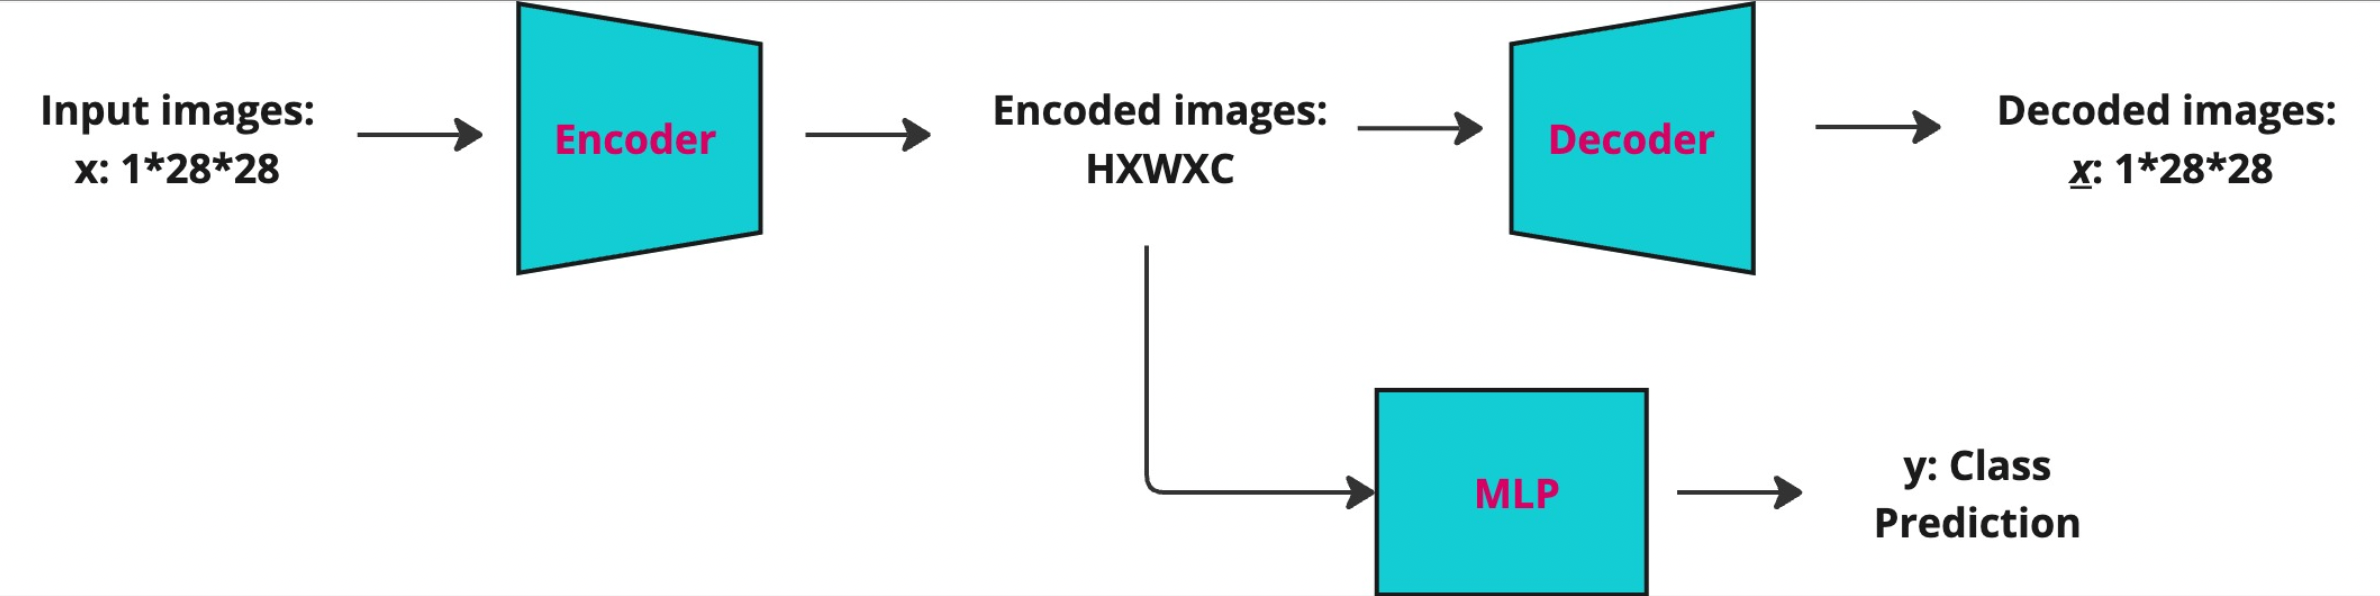

In [2]:
#check whether GPU is available or not
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#download the MNIST dataset
train_data = datasets.MNIST(root = './data', train = True, transform = transforms.ToTensor(), download = True)
test_data = datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 353075601.00it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 126183014.40it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 177148857.50it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 7541777.03it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Provide information about the split of the dataset
training_data = train_data.data.shape
testing_data = test_data.data.shape
print(f"Total number of data in the training set is {training_data[0]} that includes {training_data[1]}x{training_data[2]} size images")
print(f"Total number of data in the test set is {testing_data[0]} that includes {testing_data[1]}x{testing_data[2]} size images")

Total number of data in the training set is 60000 that includes 28x28 size images
Total number of data in the test set is 10000 that includes 28x28 size images


In [5]:
# Define dataloaders

batch_size = 100
train_loader = DataLoader(dataset = train_data,
                          batch_size = batch_size,
                          shuffle = True)

test_loader = DataLoader(dataset = test_data,
                         batch_size = batch_size,
                         shuffle = False)

In [6]:
# Encoder CNN
# input size will be NxCxHxw

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, kernel_size=2, stride=1, padding=1)
    self.conv2 = nn.Conv2d(8, 16, kernel_size=2, stride=2, padding=1)
    self.conv3 = nn.Conv2d(16, 3, kernel_size=1)

    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = self.relu(self.conv3(x))

    return x

In [7]:
encoder = Encoder().to(device)
summary(encoder, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 29, 29]              40
              ReLU-2            [-1, 8, 29, 29]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4             [-1, 16, 8, 8]             528
              ReLU-5             [-1, 16, 8, 8]               0
         MaxPool2d-6             [-1, 16, 4, 4]               0
            Conv2d-7              [-1, 3, 4, 4]              51
              ReLU-8              [-1, 3, 4, 4]               0
Total params: 619
Trainable params: 619
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.00
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


In [8]:
# Decoder CNN
# input size will be the output of Encoder

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.t_conv1 = nn.ConvTranspose2d(3, 16, kernel_size=3,stride=1)
    self.t_conv2 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2)
    self.t_conv3 = nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2)

    self.relu = nn.ReLU()

  def forward(self, x):

    x = self.relu(self.t_conv1(x))
    x = self.relu(self.t_conv2(x))
    x = self.relu(self.t_conv3(x))

    return x


In [9]:
# Let's see the feature vectors layer by layer for the Decoder
decoder = Decoder().to(device)
summary(decoder, (3,4,4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 16, 6, 6]             448
              ReLU-2             [-1, 16, 6, 6]               0
   ConvTranspose2d-3            [-1, 8, 13, 13]           1,160
              ReLU-4            [-1, 8, 13, 13]               0
   ConvTranspose2d-5            [-1, 1, 28, 28]             129
              ReLU-6            [-1, 1, 28, 28]               0
Total params: 1,737
Trainable params: 1,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.01
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [10]:
# Define the loss function and optimizer

loss_func = nn.MSELoss()
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

In [11]:
# Train the model

num_epochs = 20
loss_history = []
for each_epoch in range(num_epochs):
  for i, (images, label) in enumerate(train_loader):
    images = images.to(device)

    optimizer.zero_grad()
    encod = encoder(images)
    decod = decoder(encod)
    loss = loss_func(decod, images)
    loss.backward()
    optimizer.step()

    if (i+1) % batch_size == 0:
      loss_history.append(loss.item())
      print("Epoch [%d/%d], Step [%d/%d], Loss: %.4f"
            %(each_epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))

Epoch [1/20], Step [100/600], Loss: 0.0677
Epoch [1/20], Step [200/600], Loss: 0.0549
Epoch [1/20], Step [300/600], Loss: 0.0521
Epoch [1/20], Step [400/600], Loss: 0.0476
Epoch [1/20], Step [500/600], Loss: 0.0433
Epoch [1/20], Step [600/600], Loss: 0.0411
Epoch [2/20], Step [100/600], Loss: 0.0394
Epoch [2/20], Step [200/600], Loss: 0.0397
Epoch [2/20], Step [300/600], Loss: 0.0395
Epoch [2/20], Step [400/600], Loss: 0.0394
Epoch [2/20], Step [500/600], Loss: 0.0376
Epoch [2/20], Step [600/600], Loss: 0.0383
Epoch [3/20], Step [100/600], Loss: 0.0379
Epoch [3/20], Step [200/600], Loss: 0.0366
Epoch [3/20], Step [300/600], Loss: 0.0370
Epoch [3/20], Step [400/600], Loss: 0.0369
Epoch [3/20], Step [500/600], Loss: 0.0365
Epoch [3/20], Step [600/600], Loss: 0.0348
Epoch [4/20], Step [100/600], Loss: 0.0352
Epoch [4/20], Step [200/600], Loss: 0.0353
Epoch [4/20], Step [300/600], Loss: 0.0336
Epoch [4/20], Step [400/600], Loss: 0.0346
Epoch [4/20], Step [500/600], Loss: 0.0348
Epoch [4/20

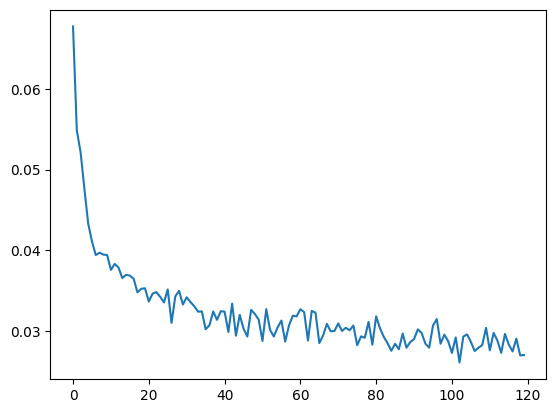

In [12]:
# plot the training loss curve

import matplotlib.pyplot as plt
plt.plot(loss_history);

In [14]:
# Define a MLP for the classification problem

class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(3*4*4, 120)    
    self.fc2 = nn.Linear(120, 10)
    self.relu = nn.ReLU()

   
  def forward(self, x):
    x = x.view(-1, 3*4*4)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# Create an instance 
mlp = MLP().to(device)

In [16]:
# Define the other parameters
loss_fun = nn.CrossEntropyLoss()
params = mlp.parameters()
optimizer = torch.optim.Adam(params, lr=1.e-3, weight_decay=0.01)

Epoch [1/10], Step [100/600], Loss: 1.0423
Epoch [1/10], Step [200/600], Loss: 0.9061
Epoch [1/10], Step [300/600], Loss: 0.8576
Epoch [1/10], Step [400/600], Loss: 0.7441
Epoch [1/10], Step [500/600], Loss: 0.6698
Epoch [1/10], Step [600/600], Loss: 0.7155
Epoch [2/10], Step [100/600], Loss: 0.5801
Epoch [2/10], Step [200/600], Loss: 0.5906
Epoch [2/10], Step [300/600], Loss: 0.5179
Epoch [2/10], Step [400/600], Loss: 0.5564
Epoch [2/10], Step [500/600], Loss: 0.4972
Epoch [2/10], Step [600/600], Loss: 0.6519
Epoch [3/10], Step [100/600], Loss: 0.6638
Epoch [3/10], Step [200/600], Loss: 0.4326
Epoch [3/10], Step [300/600], Loss: 0.6641
Epoch [3/10], Step [400/600], Loss: 0.5068
Epoch [3/10], Step [500/600], Loss: 0.5086
Epoch [3/10], Step [600/600], Loss: 0.4925
Epoch [4/10], Step [100/600], Loss: 0.4696
Epoch [4/10], Step [200/600], Loss: 0.4462
Epoch [4/10], Step [300/600], Loss: 0.4193
Epoch [4/10], Step [400/600], Loss: 0.5823
Epoch [4/10], Step [500/600], Loss: 0.3785
Epoch [4/10

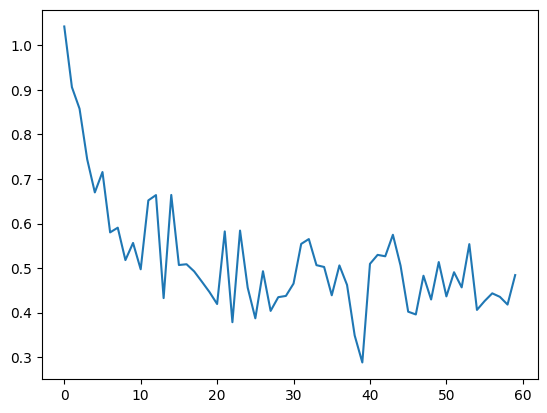

In [17]:
# Train the model 
num_epochs = 10
loss_history = []
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    latent = encoder(images)
    output = mlp(latent)
    loss = loss_fun(output, labels)
    loss.backward()
    optimizer.step()
    
    if (i+1) % batch_size == 0:
      loss_history.append(loss.item())
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))
      

plt.plot(loss_history)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss Values")
plt.title("Loss Curve for Training of only MLP")
plt.show()

In [18]:
def evaluate(encoder, classifier):
  # Run the trained model on the testing set
  correct = 0
  total = 0
  for images,labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
  
    out = classifier(encoder(images))
    _, predicted_labels = torch.max(out,1)
    correct += (predicted_labels == labels).sum()
    total += labels.size(0)

  print('Percent correct: %.3f %%' %((100*correct)/(total+1)))


evaluate(encoder, mlp)

Percent correct: 87.341 %


Epoch [1/20], Step [100/600], Loss: 2.2870
Epoch [1/20], Step [200/600], Loss: 0.9839
Epoch [1/20], Step [300/600], Loss: 0.7896
Epoch [1/20], Step [400/600], Loss: 0.7281
Epoch [1/20], Step [500/600], Loss: 0.6543
Epoch [1/20], Step [600/600], Loss: 0.5781
Epoch [2/20], Step [100/600], Loss: 0.7500
Epoch [2/20], Step [200/600], Loss: 0.6548
Epoch [2/20], Step [300/600], Loss: 0.4954
Epoch [2/20], Step [400/600], Loss: 0.5343
Epoch [2/20], Step [500/600], Loss: 0.5955
Epoch [2/20], Step [600/600], Loss: 0.5935
Epoch [3/20], Step [100/600], Loss: 0.3645
Epoch [3/20], Step [200/600], Loss: 0.5389
Epoch [3/20], Step [300/600], Loss: 0.5108
Epoch [3/20], Step [400/600], Loss: 0.4459
Epoch [3/20], Step [500/600], Loss: 0.4188
Epoch [3/20], Step [600/600], Loss: 0.4008
Epoch [4/20], Step [100/600], Loss: 0.3785
Epoch [4/20], Step [200/600], Loss: 0.5453
Epoch [4/20], Step [300/600], Loss: 0.5521
Epoch [4/20], Step [400/600], Loss: 0.4659
Epoch [4/20], Step [500/600], Loss: 0.3412
Epoch [4/20

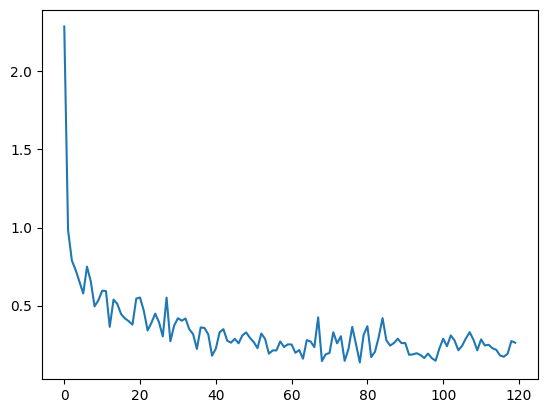

In [22]:
# Define the loss function and the optimizer for training encoder and mlp at the same time
net1 = Encoder().to(device)
net3 = MLP().to(device)

loss_fun = nn.CrossEntropyLoss()
params = list(net1.parameters()) +  list(net3.parameters())
optimizer = torch.optim.Adam(params, lr=1.e-3, weight_decay=0.01)

# Train the model 
num_epochs = 20
loss_history = []
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    latent = net1(images)
    output = net3(latent)
    loss = loss_fun(output, labels)
    loss.backward()
    optimizer.step()
    
    if (i+1) % batch_size == 0:
      loss_history.append(loss.item())
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))

In [23]:
# Run the trained model on the testing set
evaluate(net1, net3)

Percent correct: 93.181 %


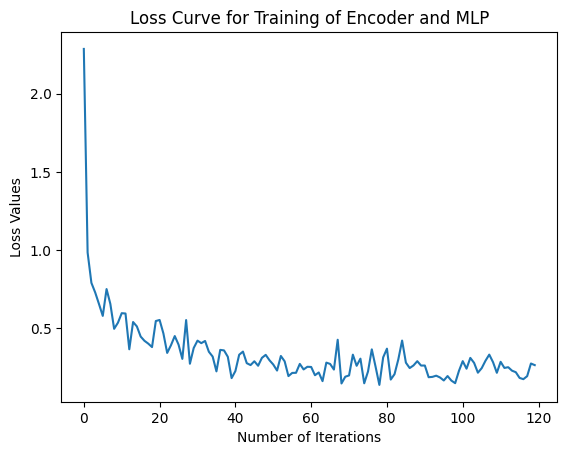

In [26]:
# Show the final loss curve
plt.plot(loss_history)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss Values")
plt.title("Loss Curve for Training of Encoder and MLP")
plt.show()
